# **Topic 1: Remote Sensing data gathering using Google Earth Engine**


Tutorial created by:

N. Falco nicolafalco@lbl.gov

D. Durden ddurden@battelleecology.org

S. Metzger smetzger@atmofacts.com

*** Copyright Notice ***

2024 Workshop - Remote Sensing and Fluxes Upscaling for Real-world Impact - Tutorial Copyright (c) 2025, The Regents of the University of California, through Lawrence Berkeley National Laboratory (subject to receipt of any required approvals from the U.S. Dept. of Energy), Battelle, through National Ecological Observatory Network (NEON), and AtmoFacts. All rights reserved.

This software is available under the GNU Affero General Public License
(“AGPL”) v3. If you have questions about your rights to use or distribute this
software, please contact Berkeley Lab's Intellectual Property Office at
 IPO@lbl.gov.

NOTICE.  This Software was developed under funding from the U.S. Department
of Energy and the U.S. Government consequently retains certain rights.  As
such, the U.S. Government has been granted for itself and others acting on
its behalf a paid-up, nonexclusive, irrevocable, worldwide license in the
Software to reproduce, distribute copies to the public, prepare derivative
works, and perform publicly and display publicly, and to permit others to do so.

#First steps:



1.   MAKE A COPY OF THIS NOTEBOOK: File -> save a copy on Drive -> open that file (located in the "Colab notebooks" folder in "My Drive")

2.   ADD YOUR PROJECT ACCOUNT (e.g., ee-yourprojectname) to the Initialization of Google Earth Engine cell  





---


## **PART 1. Connect to Google Drive and Google Earth Engine**

We mount Google drive, where the data is stored.
We then initialize GEE.

NOTE: the Google account used to access Google Drive and this notebook and the account for Google Earth Engine have to be the same one.


In [ ]:
# Packages needed

!pip install earthengine-api
!pip install geopandas


In [ ]:
# Mount of Google Drive

from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# Initialization of Google Earth Engine

import ee

# Trigger the authentication flow.\
ee.Authenticate()

# Initialize the Earth Engine module: remember to add your project name (e.g., ee-yourprojectname)
ee.Initialize(project = 'ee-yourprojectname')




---


## **PART 2. Remote Sensing data gathering with GEE**

In this part we will

1.   Use GEE to obtaine and pre-process Landsat 8
datasets
2.   Band operations to compute vegetation indices such
as NDVI, NIRv, and EVI
3.   Extract a time-series and compared the VIs over a
selected area


**FLUX TOWER site**


As target areas we will consider the area surrounding [US-xUN flux tower](https://ameriflux.lbl.gov/sites/siteinfo/US-xUN) at the  at the University of Notre Dame Environmental Research Center
Link to the site: http://www.neonscience.org/field-sites/field-sites-map/UNDE

Lat: 46.2339
Lon: -89.5373


**On-line GEE additional tutorials**


You can find several tutorials on [GEE Python API](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)


### Importing Landsat 8 and MODIS LAI collections

GEE offers the opportunity to acess to several open data throught it's [data catalog](https://developers.google.com/earth-engine/datasets). Today, we consider the use of


1. Landsat 8 surface reflectance collection 2 (the latest) tier 1 (best quality) L2 (athmospheric and geometrical corrections have been applied) -> [Landsat 8 Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2#description)

2. MODIS LAI -> [MODIS Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD15A3H)



In [ ]:
# Import Landsat 8 surfance reflectance (the whole collection)
L8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Import MODIS LAI (the whole collection)
MODIS_collection = ee.ImageCollection('MODIS/061/MCD15A3H')


### Temporal and spatial filtering

*Time filter*

Now we have our collection of images. The next step is to narrow down the selection to the location and time period we are intrested. To do that, we apply filters to the collection.

In [ ]:
# Time filter: Acquistion period of interest
initial_date = '2019-08-01' # included
final_date = '2019-09-01' #excluded

*Spatial filter*

We define a geometry (area of 6x6 km) surrounding the flux tower. Here we convert UTM coordinates into lat/lon and create a polygon geometry

In [ ]:
# Geometry 6 x 6 km

rectROI = [[-89.575016,46.205893],
           [-89.577550,46.260018],
           [-89.499513,46.261752],
           [-89.497056,46.207623]]

## This is used as input for the filter
AOI_6km = ee.Geometry.Polygon(rectROI)

# Print the polygon to verify
print(AOI_6km.getInfo())

{'type': 'Polygon', 'coordinates': [[[-89.575016, 46.205893], [-89.497056, 46.207623], [-89.499513, 46.261752], [-89.57755, 46.260018], [-89.575016, 46.205893]]]}


In [ ]:
# Geometry 60 x 60 km

rectROI = [[-89.911650,45.954881],
           [-89.940326,46.494175],
           [-89.159117,46.511601],
           [-89.138042,45.971984]]

AOI_60km = ee.Geometry.Polygon(rectROI)

# Print the polygon to verify
print(AOI_60km.getInfo())

{'type': 'Polygon', 'coordinates': [[[-89.91165, 45.954881], [-89.138042, 45.971984], [-89.159117, 46.511601], [-89.940326, 46.494175], [-89.91165, 45.954881]]]}


Let's apply the filters to our collections


In [ ]:
L8f = L8_collection.filterDate(initial_date, final_date).filterBounds(AOI_6km)

MLAIf = MODIS_collection.filterDate(initial_date, final_date).filterBounds(AOI_6km)

Let's check the available dates in our collection.
This functions reads the metadata from each acquistions and reports the acquistion date.


In [ ]:
# Function to extract the dates from the collection

def get_image_collection_dates(collection_name):
    """
    Args:
      collection_name: Image collection name

    Returns:
      dates: list of dates in the collection
    """
    # Load the image collection
    collection = ee.ImageCollection(collection_name)

    # Get the list of image IDs (which include the dates)
    ids = collection.aggregate_array('system:id').getInfo()

    # Extract dates from the IDs
    dates = [ee.Image(id).date().format('YYYY-MM-dd').getInfo() for id in ids]

    return dates

In [ ]:
dates = get_image_collection_dates(L8f)

# Print the available dates
for date in dates:
    print(date)

2019-08-11
2019-08-27
2019-08-02


In [ ]:
dates = get_image_collection_dates(MLAIf)

for date in dates:
    print(date)

2019-08-01
2019-08-05
2019-08-09
2019-08-13
2019-08-17
2019-08-21
2019-08-25
2019-08-29




---


### Band operations

Similarly to the previous filters, we can define functions to perform band operations and apply them to all the images composing our collection.


NOTE: Often, datasets in GEE have been scaled to optimize their storage. Therefore, as first step we need to bring the dataset to its original scale by applying the scale factors provided in the dataset description.

To do that we use the GEE function ".map"

In [ ]:
# function that applies scale factors to Landsat 8 spectral bands

def applyScaleFactors(image):
    """
    Args:
        image: Landsat 8 image

    Returns:
        Rescaled Landsat 8 image with bands converted to Float32
    """
    # Apply scale factors to optical bands
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2).toFloat()

    # Apply scale factors to thermal bands if needed
    # thermalBand = image.select('ST_B.').multiply(0.00341802).add(149.0).toFloat()

    # Add rescaled bands to the image, ensuring they are Float32
    return image.addBands(srcImg=opticalBands, overwrite=True).toFloat()
    # .addBands(srcImg=thermalBand, overwrite=True).toFloat() if thermal bands are included


# apply the scale factor to L8f
L8f = L8f.map(applyScaleFactors)
#L8f.getInfo()

*Vegetation indices*

Let's defined functions to compute NDVI, EVI, NIRv across the whole collection.

1. $NDVI = \frac{NIR-Red}{NIR+Red}$

2. $NIRv = NDVI * NIR$

3. $EVI = 2.5 * \left(\frac{NIR - Red}{NIR + 6*Red -7.5*Blue +1}\right)$

For Landsat 8
- NIR = band 5 (SR_B5)
- Red = band 4 (SR_B4)
- Blue = band 2 (SR_B2)

In [ ]:
# NDVI
def addNDVI_L8(image):

  NDVI = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
  return image.addBands(NDVI).toFloat()

# NIRV
def addNIRv_L8(image):

  NIRV = image.select('NDVI').multiply(image.select('SR_B5')).rename('NIRV')
  return image.addBands(NIRV).toFloat()

# EVI
def addEVI_L8(image):
  EVI = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR' : image.select('SR_B5'),
      'RED' : image.select('SR_B4'),
      'BLUE': image.select('SR_B2')}).rename('EVI')
  return image.addBands(EVI).toFloat()

As we did for the scale factors, we can use ".map" to compute the VI for each image in our collection.
Here, we create another collection L8f_VI that will contain all the bands and the VIs


In [ ]:
L8f_VI = (L8f
    .map(addNDVI_L8)
    .map(addEVI_L8)
    .map(addNIRv_L8)
    )

***Let's check how these VI look like by printing a static image from the collection***

To do that we need

- to select the bands we are intrested in
- to apply a reducer (operation that aggregates data e.g., max())
- we can also further narrow down the time period on which apply the reducer. Here we select images acuired in a specific day.

In [ ]:
L8f_VI_rast = L8f_VI.select(['SR_B1', 'SR_B2', 'SR_B3','SR_B4', 'SR_B5', 'SR_B6','SR_B7','NDVI','EVI','NIRV','QA_PIXEL']).filterDate('2019-08-02', '2019-08-03').max()

# show structure of the image extracted
L8f_VI_rast.getInfo()


{'type': 'Image',
 'bands': [{'id': 'SR_B1',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B2',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B3',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B4',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B5',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B6',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B7',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_trans

Let's do the same for the MODIS LAI - remmeber that MODIS has an acquisition on 2019-08-01

In [ ]:
MLAIf_rast = MLAIf.filterDate('2019-08-01', '2019-08-03').max()

# show structure of the image extracted
MLAIf_rast.getInfo()

{'type': 'Image',
 'bands': [{'id': 'Fpar',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'Lai',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'FparLai_QC',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'FparExtra_QC',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'FparStdDev',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'LaiStdDev',
   'data_type': {'type': 'PixelType',
    'precision': 'int',




---


### Plotting

#### Hystogram streatching

In [ ]:
# Hystogram function

def apply_histogram_stretching(image, region, scale, percentiles=[2, 98]):
    """
    Apply histogram stretching to an image based on given percentiles.

    Args:
        image (ee.Image): The input image to be stretched.
        region (ee.Geometry): The region over which to calculate the percentiles.
        scale (int): The scale in meters at which to perform the reduction.
        percentiles (list): List of two percentiles for stretching (e.g., [2, 98]).

    Returns:
        ee.Image: The histogram-stretched image.
    """
    # Calculate the percentiles for the image bands
    pct = image.reduceRegion(
        reducer=ee.Reducer.percentile(percentiles),
        geometry=region,
        scale=scale,
        bestEffort=True
    ).getInfo()

    # Extract min and max values for each band
    bands = image.bandNames().getInfo()
    min_values = [pct[f'{band}_p{percentiles[0]}'] for band in bands]
    max_values = [pct[f'{band}_p{percentiles[1]}'] for band in bands]

    # Apply histogram stretching manually for each band
    def rescale(band, min_val, max_val):
        return image.select(band).unitScale(min_val, max_val).multiply(255).clamp(0, 255).toUint8()

    stretched_bands = [rescale(band, min_val, max_val) for band, min_val, max_val in zip(bands, min_values, max_values)]
    stretched_image = ee.Image(stretched_bands).rename(bands)

    return stretched_image


In [ ]:
# Apply histogram stretching to Landsat 8
L8f_VI_rast_stretched = apply_histogram_stretching(image=L8f_VI_rast, region=AOI_6km, scale =30)

# Apply histogram stretching to MODIS LAI
MLAIf_rast_stretched = apply_histogram_stretching(image=MLAIf_rast, region=AOI_6km, scale=500)


#### Plotting VIs

In [ ]:
# Plot L8 compoite RGB

from IPython.display import Image

url = L8f_VI_rast_stretched.getThumbUrl({
        'dimensions': 512,
        'region': AOI_6km,
        'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
        'format': 'png'
    })

# Print the URL
print(url)

# Display the thumbnail
print('\nComposite image thumbnail is loading, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-nicolafalco/thumbnails/02eefcb268fa2e3cfc2530e671fcb18a-6aa492a30abdc202eb6dc811da42c1f4:getPixels

Composite image thumbnail is loading, it may take a moment...


In [ ]:
# Plot NDVI

from IPython.display import Image

# Create a URL to the styled image
url = L8f_VI_rast_stretched.getThumbUrl({
    'dimensions': 512,
    'region': AOI_6km,
    'bands': 'NDVI',
    'palette': ['red','yellow','green']})

# Print the URL
print(url)

# Display the thumbnail here below
print('\nNDVI thumbnail is loading, it may take a moment...')
Image(url=url)


https://earthengine.googleapis.com/v1/projects/ee-nicolafalco/thumbnails/1efdc44f97c6979b9031b9d3be545523-7b5b1ad019ef28c94adef6896317b8a1:getPixels

NDVI thumbnail is loading, it may take a moment...


In [ ]:
# Plot NIRV

# Create a URL to the styled image
url = L8f_VI_rast_stretched.getThumbUrl({
    'dimensions': 512,
    'region': AOI_6km,
    'bands': 'NIRV',
    'palette': ['red','yellow','green']})

# Print the URL
print(url)

# Display the thumbnail here below
print('\nNIRv thumbnail is loading, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-nicolafalco/thumbnails/78ebce56c1e52ce393dc469b72eaf905-79847c72ec6a7ad06d885e1dc1ae3bca:getPixels

NIRv thumbnail is loading, it may take a moment...


In [ ]:
# Plot EVI

# Create a URL to the styled image
url = L8f_VI_rast_stretched.getThumbUrl({
    'dimensions': 512,
    'region': AOI_6km,
    'bands': 'EVI',
    'palette': ['red','yellow','green']})

# Print the URL
print(url)

# Display the thumbnail here below
print('\nEVI thumbnail is loading, it may take a moment...')
Image(url=url)


https://earthengine.googleapis.com/v1/projects/ee-nicolafalco/thumbnails/c7c7bffb8b1b5b044f958a72c20f8d26-a10d2f239e68b09f2a57ac5157871bd3:getPixels

EVI thumbnail is loading, it may take a moment...


In [ ]:
# Plot MODIS LAI

# Create a URL to the styled image
url = MLAIf_rast_stretched.getThumbUrl({
        'dimensions': 512,
        'region': AOI_6km,
        'bands': 'Lai',
        'palette': ['red','yellow','green']
    })

# Print the URL
print(url)

# Display the thumbnail here below
print('\nMODIS LAI thumbnail is loading, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-nicolafalco/thumbnails/506342f04175d4a15ea43901fe9c35b0-73f4e18e0d39796575e85e9f2579dac7:getPixels

MODIS LAI thumbnail is loading, it may take a moment...


We will now gather and plot the data for the bigger region (60 x 60km)

In [ ]:
url = L8f_VI_rast.getThumbUrl({
    'dimensions': 512,
    'region': AOI_60km,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']
    #'palette': ['red','orange','yellow','green','blue']
    })

# Display the thumbnail here below
print('\nEVI thumbnail is loading, it may take a moment...')
Image(url=url)



EVI thumbnail is loading, it may take a moment...


#### Landsat 8 and MODIS quality assesment

In [ ]:
#Function to mask clouds, shadow and bad pixels for Landsat 8.

def apply_qa_mask_Landsat8(image):
  """
  Apply QA mask to the Landsat 8 image.

  Args:
    image (ee.Image): A Landsat 8 image.

  Returns:
    ee.Image: QA-masked Landsat 8 image.
  """
  # Bits 7, 4, 5, 3, 1, 2  are water, cloud shadow, snow, cloud, dilatated clouds, cirrus respectively.
  cloudShadowBitMask = (1 << 4)
  cloudBitMask = (1 << 3)
  snowBitMask = (1 << 5)
  waterBitMask = (1 << 7)
  dilatatedCloudBitMask = (1 << 1);
  cirrusBitMask = (1 << 2)

  # Get the pixel QA band.
  pixelQA = image.select('QA_PIXEL').int()

  # Both flags should be set to zero, indicating clear conditions.
  mask = pixelQA.bitwiseAnd(cloudShadowBitMask).eq(0).And(pixelQA.bitwiseAnd(cloudBitMask).eq(0)).And(pixelQA.bitwiseAnd(snowBitMask).eq(0)).And(pixelQA.bitwiseAnd(waterBitMask).eq(0)).And(pixelQA.bitwiseAnd(dilatatedCloudBitMask).eq(0)).And(pixelQA.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask)




def apply_qa_mask_MODIS(image):
  """
  Apply QA mask to the MODIS LAI image.

  Args:
    image (ee.Image): A MODIS LAI image.

  Returns:
    ee.Image: QA-masked MODIS LAI image.

  """
  # Extract the QA band
  qa = image.select('FparLai_QC')

  # Define QA mask (bitwiseAnd with binary patterns)
  # Good quality (bits 0-1 == 00)
  good_quality = qa.bitwiseAnd(3).eq(0)

  # Mask out bad quality data
  lai = image.select('Lai').updateMask(good_quality)

  return lai



L8f_VI_rast_QA = L8f_VI.filterDate('2019-08-02', '2019-08-03').map(apply_qa_mask_Landsat8).max()

MLAIf_rast_QA = MLAIf.filterDate('2019-08-01', '2019-08-02').map(apply_qa_mask_MODIS).max()


Let's plot the masked Landsat 8 RGB

In [ ]:
url = L8f_VI_rast_QA.getThumbUrl({
    'dimensions': 512,
    'region': AOI_60km,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']
    #'palette': ['red','orange','yellow','green','blue']
    })

# Display the thumbnail here below
print('\nEVI thumbnail is loading, it may take a moment...')
Image(url=url)


EVI thumbnail is loading, it may take a moment...


Let's plot the masked Landsat 8 EVI

In [ ]:
url = L8f_VI_rast_QA.getThumbUrl({
    'dimensions': 512,
    'region': AOI_60km,
    'bands': 'EVI',
    'palette': ['red','orange','yellow','green','blue']
    })

# Display the thumbnail here below
print('\nEVI thumbnail is loading, it may take a moment...')
Image(url=url)


EVI thumbnail is loading, it may take a moment...


Let's plot the masked MODIS LAI

In [ ]:
# Plot MODIS LAI

# Create a URL to the styled image
url = MLAIf_rast_QA.getThumbUrl({
        'dimensions': 512,
        'region': AOI_60km,
        'bands': 'Lai',
        'palette': ['red','orange','yellow','green','blue']
    })

# Print the URL
print(url)

# Display the thumbnail here below
print('\nMODIS LAI thumbnail is loading, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-nicolafalco/thumbnails/320aeefac903cf3a247fc6cffe8e81b8-405eceda5c327f61a834b4753e7b11b7:getPixels

MODIS LAI thumbnail is loading, it may take a moment...




---


### Saving images as Geotiffs to your GDrive

Landsat 8

In [ ]:
# Region 6x6 km
task = ee.batch.Export.image.toDrive(image=L8f_VI_rast,
                                     description='Landsat8_VI_6km',
                                     scale=30,
                                     region=AOI_6km,
                                     folder='Colab Notebooks',
                                     fileNamePrefix= 'Landsat8_VI_6km',
                                     crs='EPSG:32616',
                                     fileFormat='GeoTIFF')
task.start()

In [ ]:
task.status()

{'state': 'READY',
 'description': 'Landsat8_VI_6km',
 'priority': 100,
 'creation_timestamp_ms': 1720599482041,
 'update_timestamp_ms': 1720599482041,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'JU6SSOXGVNE4IAFPJC7OPJ7K',
 'name': 'projects/ee-nicolafalco/operations/JU6SSOXGVNE4IAFPJC7OPJ7K'}

In [ ]:
# Region 60x60 km
task = ee.batch.Export.image.toDrive(image=L8f_VI_rast_QA,
                                     description='Landsat8_VI_60km_QA',
                                     scale=30,
                                     region=AOI_60km,
                                     folder='Colab Notebooks',
                                     fileNamePrefix= 'Landsat8_VI_60km_QA',
                                     crs='EPSG:32616',
                                     fileFormat='GeoTIFF')
task.start()

In [ ]:
task.status()

{'state': 'READY',
 'description': 'Landsat8_VI_60km_QA',
 'priority': 100,
 'creation_timestamp_ms': 1720599482500,
 'update_timestamp_ms': 1720599482500,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'FDDGFBWHL7A7GD6LCWCS7JBA',
 'name': 'projects/ee-nicolafalco/operations/FDDGFBWHL7A7GD6LCWCS7JBA'}

MODIS

In [ ]:
# Region 6x6 km
task = ee.batch.Export.image.toDrive(image=MLAIf_rast,
                                     description='MODIS_LAI_6km',
                                     scale=500,
                                     region=AOI_6km,
                                     folder='Colab Notebooks',
                                     fileNamePrefix='MODIS_LAI_6km',
                                     crs='EPSG:32616',
                                     fileFormat='GeoTIFF')
task.start()

In [ ]:
task.status()

{'state': 'READY',
 'description': 'MODIS_LAI_6km',
 'priority': 100,
 'creation_timestamp_ms': 1720599482900,
 'update_timestamp_ms': 1720599482900,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'NHRKW6DS43NLYQ42BHCUTGLK',
 'name': 'projects/ee-nicolafalco/operations/NHRKW6DS43NLYQ42BHCUTGLK'}

In [ ]:
# Region 6x6 km
task = ee.batch.Export.image.toDrive(image=MLAIf_rast,
                                     description='MODIS_LAI_60km',
                                     scale=500,
                                     region=AOI_60km,
                                     folder='Colab Notebooks',
                                     fileNamePrefix='MODIS_LAI_60km',
                                     crs='EPSG:32616',
                                     fileFormat='GeoTIFF')
task.start()

In [ ]:
task.status()

{'state': 'READY',
 'description': 'MODIS_LAI_60km',
 'priority': 100,
 'creation_timestamp_ms': 1720599483305,
 'update_timestamp_ms': 1720599483305,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'MFHX3H5MUGVDLI2DPWPFHSMT',
 'name': 'projects/ee-nicolafalco/operations/MFHX3H5MUGVDLI2DPWPFHSMT'}

##**PART 3. Extraction of a time-series**

We will use the location of the tower US-xUN to extract our time-series.

https://ameriflux.lbl.gov/sites/siteinfo/US-xUN



In [ ]:
# Define the location of interest as a point overlapping the tower

US_xUN_lat = 46.2339
US_xUN_lon = -89.5373

xUN_poi = ee.Geometry.Point(US_xUN_lon, US_xUN_lat)

# define the time period for thetime-series (2years)
initial_date = '2017-08-01'
final_date = '2019-08-03'

### Export Landsat 8 time-series

*   Filter by date and area (using AOI)
*   Apply scale factors
*   Compute VIs

In [ ]:
# Import Landsat 8 surfance reflectance (the whole collection)
L8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

L8f = L8_collection.filterDate(initial_date, final_date).filterBounds(AOI_6km)

# apply scaling and compute VIs
L8f_VI = (L8f
          .map(applyScaleFactors)
          .map(addNDVI_L8)
          .map(addEVI_L8)
          .map(addNIRv_L8))

# let's check how big is the collection
collection_size = L8f_VI.size().getInfo()
print(collection_size)

61


We use the function ".getRegion" to obtain the data only for the pixel intersecting the point

In [ ]:
L8f_VI_poi_list = L8f_VI.getRegion(xUN_poi, 30).getInfo()

# Preview the result.
L8f_VI_poi_list[:1]

[['id',
  'longitude',
  'latitude',
  'time',
  'SR_B1',
  'SR_B2',
  'SR_B3',
  'SR_B4',
  'SR_B5',
  'SR_B6',
  'SR_B7',
  'SR_QA_AEROSOL',
  'ST_B10',
  'ST_ATRAN',
  'ST_CDIST',
  'ST_DRAD',
  'ST_EMIS',
  'ST_EMSD',
  'ST_QA',
  'ST_TRAD',
  'ST_URAD',
  'QA_PIXEL',
  'QA_RADSAT',
  'NDVI',
  'EVI',
  'NIRV']]

Now that we have our time series, we can convert the data object form GEE to pandas dataframe

In [ ]:
# function to convert GEE format to dataframe

import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

Using the function define above we convert the time series into a dataframe. During the conversion we can also select the bands we are intrested in, such as NDVI, EVI, NIRV and QA_pixel, which is used for quality control.

In [ ]:
L8f_VI_poi_df = ee_array_to_df(L8f_VI_poi_list,['NDVI','EVI','NIRV','QA_PIXEL'])

# Shape tells us the dimensions (obs x var) of the dataframe
L8f_VI_poi_df.shape

(52, 6)

In [ ]:
L8f_VI_poi_df.head(10)

,time,datetime,NDVI,EVI,NIRV,QA_PIXEL
0,1501951204669,2017-08-05 16:40:04.669,0.870197,0.692576,0.343504,23826
1,1503333609569,2017-08-21 16:40:09.569,0.845846,0.716193,0.364945,21824
2,1504716011679,2017-09-06 16:40:11.679,0.601035,0.358637,0.154364,22280
3,1506098415549,2017-09-22 16:40:15.549,-0.043020,0.598508,-0.043884,55052
4,1507480821299,2017-10-08 16:40:21.299,0.494996,0.247080,0.109338,21824
5,1510245621433,2017-11-09 16:40:21.433,0.071890,0.228952,0.053059,55052
6,1511628015669,2017-11-25 16:40:15.669,0.282223,0.233298,0.069852,22280
7,1514392815618,2017-12-27 16:40:15.618,0.661327,0.128124,0.063276,30242
8,1515775209424,2018-01-12 16:40:09.424,0.058187,0.234512,0.034644,55052
9,1521304777970,2018-03-17 16:39:37.970,-0.010757,-0.014274,-0.003333,30048


#### Plot of the time-series

To plot more signals within the same plot, we use the function twinx, which add a y-axis to the plot.

NOTE: to plot time-series in pythojn, we need to remember to sort the dataframe by "datatime"

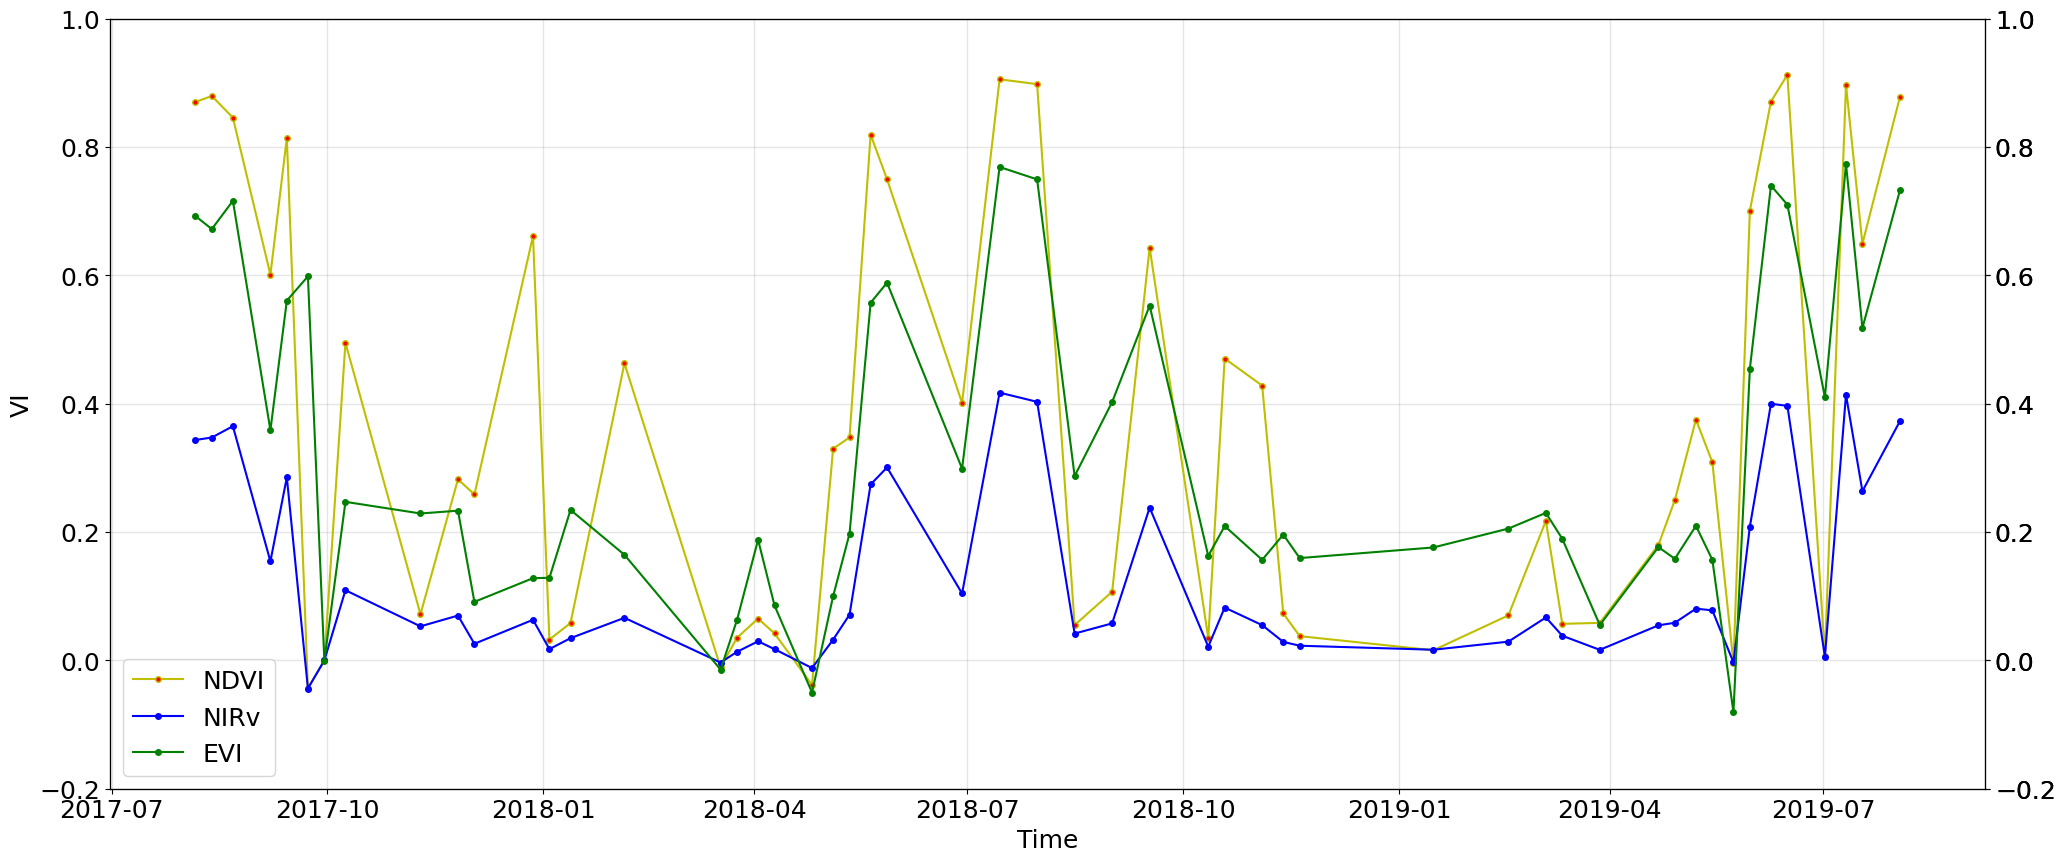

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(30, 10))
fig.subplots_adjust(right=0.75)


# Set twinx to plot multiple dataframe columns
twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above. If 1, the spines overlap
twin2.spines.right.set_position(("axes", 1))

# Sort the plot according datatime
L8f_VI_poi_df.sort_values(by='datetime', inplace=True)

# Adding scatter plots
p1, = ax.plot(L8f_VI_poi_df['datetime'], L8f_VI_poi_df['NDVI'], "-yo",label="NDVI",markersize=4, markerfacecolor='r')
p2, = twin1.plot(L8f_VI_poi_df['datetime'], L8f_VI_poi_df['NIRV'],"-bo", label="NIRv",markersize=4, markerfacecolor='b')
p3, = twin2.plot(L8f_VI_poi_df['datetime'], L8f_VI_poi_df['EVI'], "-go", label="EVI", markersize=4, markerfacecolor='g')


################# plot properties
# Set grid
ax.grid(color = "gray", linestyle = "-", linewidth = 1, alpha = 0.2)

# Set axis limits
ax.set_ylim(-0.2, 1)
twin1.set_ylim(-0.2, 1)
twin2.set_ylim(-0.2, 1)

# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("VI")
#twin1.set_ylabel("NIRv")
#twin2.set_ylabel("EVI")

# Set axis' label colors
#ax.yaxis.label.set_color(p1.get_color())
#twin1.yaxis.label.set_color(p2.get_color())
#twin2.yaxis.label.set_color(p3.get_color())

# Set axis colors
#tkw = dict(size=4, width=1.5)
#ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
#twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
#twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
#ax.tick_params(axis='x', **tkw)

# set legend
ax.legend(handles=[p1, p2, p3])

plt.show()

#### Landsat 8 Quality assesment


In the previous plot we see that each VI has a differen range of values. We can also observe a certain seasonality altough not very clear, which would make us think that some of the observations are affected by other factors, such as clouds passing over, shadow etc.


To improve this we can use the band QA_pixel to mask low quality images from the initial collection.

In [ ]:
L8f_VI_QA = L8f_VI.map(apply_qa_mask_Landsat8)

#After masking the images in the collection, we extract the time-series from the point of interest.
L8f_VI_poi_QA_list = L8f_VI_QA.getRegion(xUN_poi, 30).getInfo()

L8f_VI_poi_df_QA = ee_array_to_df(L8f_VI_poi_QA_list,['NDVI','EVI','NIRV','QA_PIXEL'])

# need to sort the the dataframe by datetime
L8f_VI_poi_df_QA.sort_values(by='datetime', inplace=True)

# size fo the dataframe
L8f_VI_poi_df_QA.shape

# first 5 rows of the dataframe
#L8_VI_df_filtered.head(5)

(16, 6)

After applying the quality check, we went from having 52 acquistions to 16.

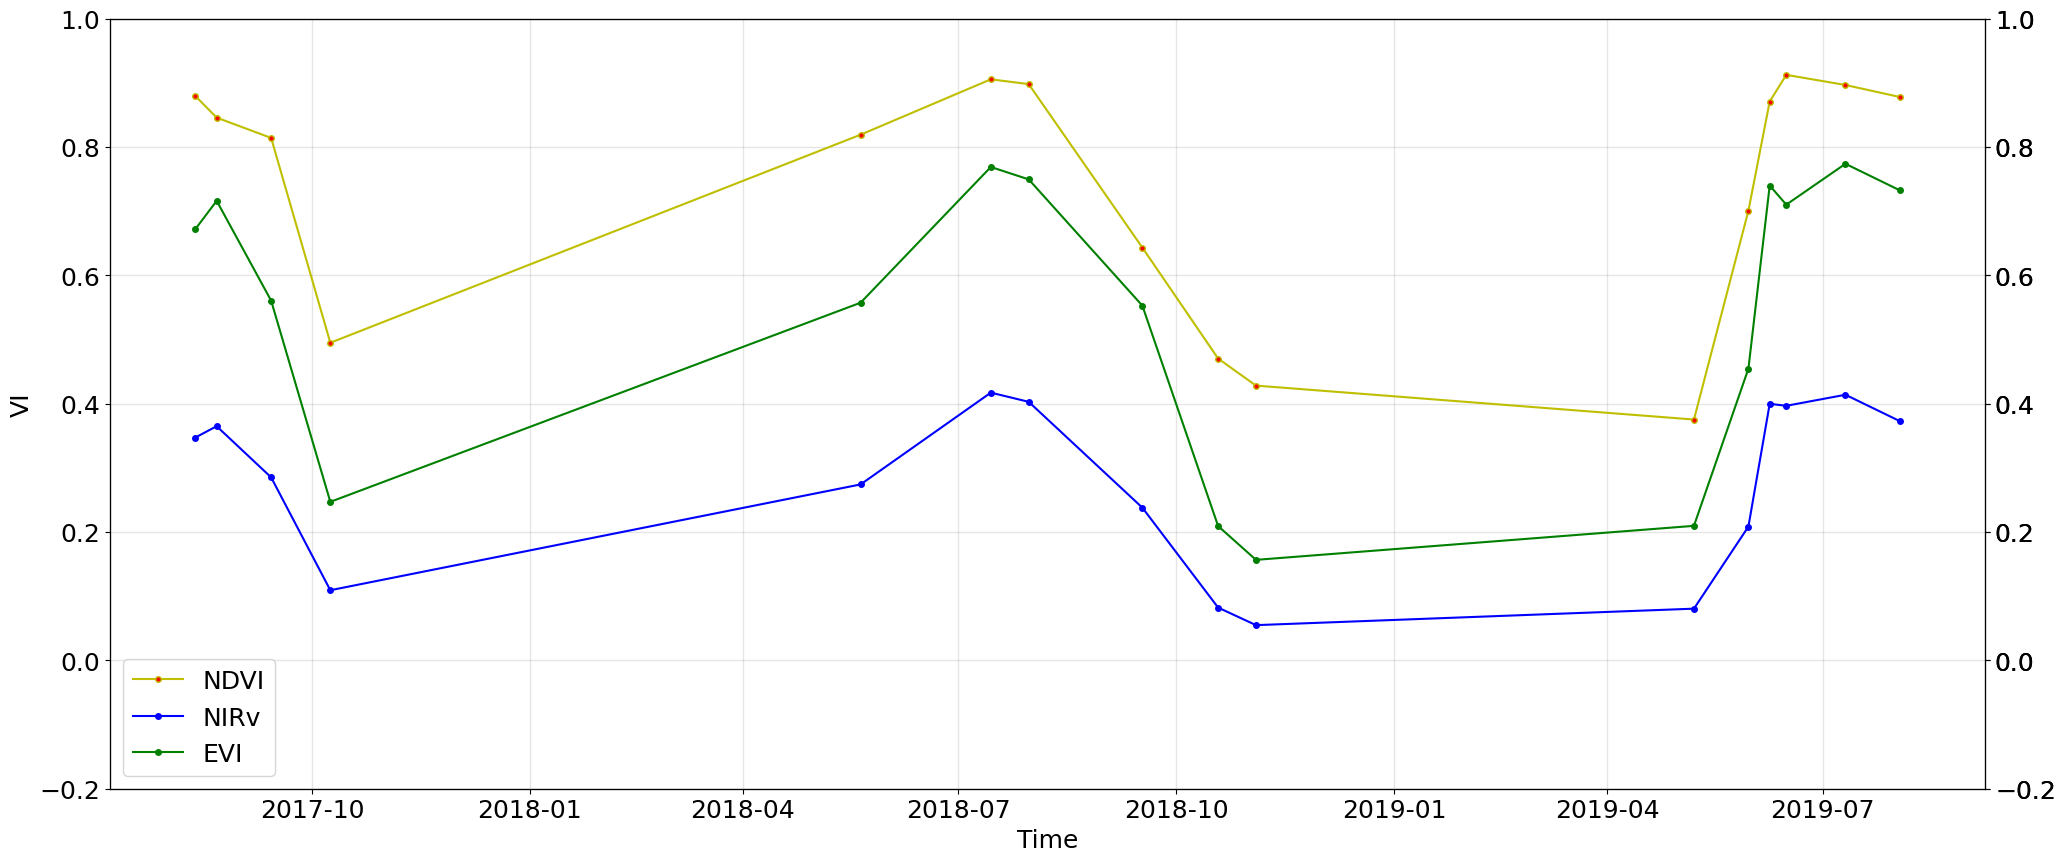

In [ ]:
plt.rcParams.update({'font.size': 18})

df = L8f_VI_poi_df_QA

fig, ax = plt.subplots(figsize=(30, 10))
fig.subplots_adjust(right=0.75)

# Set twinx to plot multiple dataframe columns
twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above. If 1, the spines overlap
twin2.spines.right.set_position(("axes", 1))

# Adding scatter plots
df.sort_values(by='datetime', inplace=True)

p1, = ax.plot(df['datetime'], df['NDVI'], "-yo",label="NDVI",markersize=4, markerfacecolor='r')
p2, = twin1.plot(df['datetime'], df['NIRV'],"-bo", label="NIRv",markersize=4, markerfacecolor='b')
p3, = twin2.plot(df['datetime'], df['EVI'], "-go", label="EVI", markersize=4, markerfacecolor='g')


################# plot properties
# Set grid
ax.grid(color = "gray", linestyle = "-", linewidth = 1, alpha = 0.2)

# Set axis limits
ax.set_ylim(-0.2, 1)
twin1.set_ylim(-0.2, 1)
twin2.set_ylim(-0.2, 1)

# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("VI")

# set legend
ax.legend(handles=[p1, p2, p3])

plt.show()

#### Save the dataframe as csv

In [ ]:
L8f_VI_poi_df_QA.to_csv('/content/drive/MyDrive/Colab Notebooks/L8f_VI_poi_df_QA.csv', index=False)

### Export MODIS time-series

In [ ]:
# Import Landsat 8 surfance reflectance (the whole collection)
MODIS_collection = ee.ImageCollection('MODIS/061/MCD15A3H')

MLAIf_AOI = MODIS_collection.filterDate(initial_date, final_date).filterBounds(AOI_6km)

# let's check how big is the collection
collection_size = MLAIf_AOI.size().getInfo()
print(collection_size)

185


#### MODIS Quality assesment

In [ ]:
# Apply QA mask to each image in the collection
MLAIf_AOI_QA = MLAIf_AOI.map(apply_qa_mask_MODIS)

# Select the pixel overlapping with the tower location
MLAIf_poi_list = MLAIf_AOI_QA.getRegion(xUN_poi, 500).getInfo()

# Preview the result.
MLAIf_poi_list[:1]

[['id', 'longitude', 'latitude', 'time', 'Lai']]

In [ ]:
MLAIf_poi_df_QA = ee_array_to_df(MLAIf_poi_list,['Lai'])

# Shape tells us the dimensions (obs x var) of the dataframe
MLAIf_poi_df_QA.shape

(60, 3)

In [ ]:
MLAIf_poi_df_QA.head(10)

,time,datetime,Lai
0,1501545600000,2017-08-01,62
1,1501891200000,2017-08-05,28
2,1502236800000,2017-08-09,47
3,1502582400000,2017-08-13,53
4,1502928000000,2017-08-17,46
5,1503273600000,2017-08-21,57
6,1503619200000,2017-08-25,44
7,1503964800000,2017-08-29,52
9,1504656000000,2017-09-06,50
10,1505001600000,2017-09-10,48


#### Plotting Landsat and MODIS data

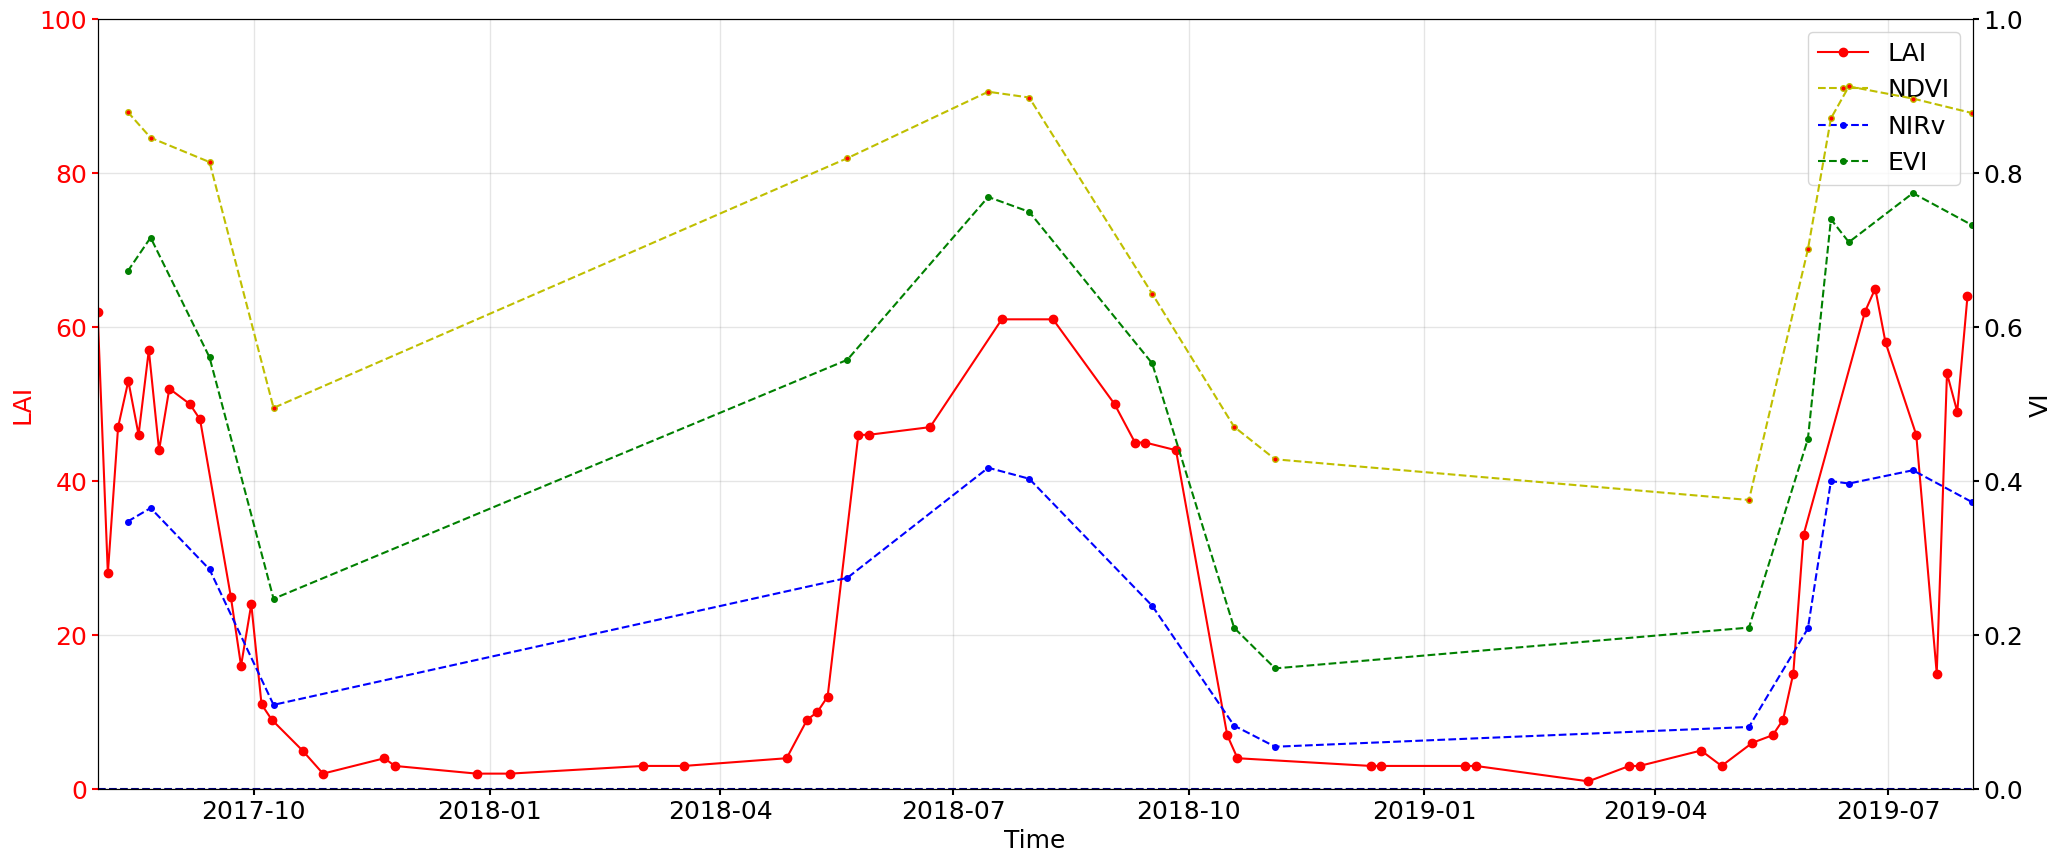

In [ ]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(30, 10))
fig.subplots_adjust(right=0.75)

df_L = L8f_VI_poi_df_QA
df_M = MLAIf_poi_df_QA

# Set twinx to plot multiple dataframe columns
twin1 = ax.twinx()
#twin2 = ax.twinx()
#twin3 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above. If 1, the spines overlap
#twin2.spines.right.set_position(("axes", 1.1))
#twin3.spines.right.set_position(("axes", 1.1))

df_L.sort_values(by='datetime', inplace=True)
df_M.sort_values(by='datetime', inplace=True)

# Adding scatter plots

p1, = ax.plot(df_M['datetime'], df_M['Lai'], "-ro",label="LAI")
p2, = twin1.plot(df_L['datetime'], df_L['NDVI'], "--yo",label="NDVI",markersize=4, markerfacecolor='r')
p3, = twin1.plot(df_L['datetime'], df_L['NIRV'],"--bo", label="NIRv",markersize=4, markerfacecolor='b')
p4, = twin1.plot(df_L['datetime'], df_L['EVI'], "--go", label="EVI", markersize=4, markerfacecolor='g')

# zero line
ax.axhline(y = 0, color = 'navy', linestyle = '--')

################# plot properties
# Set grid
ax.grid(color = "gray", linestyle = "-", linewidth = 1, alpha = 0.2)

# Set axis limits
ax.set_xlim(np.datetime64("2017-08-01"), np.datetime64("2019-08-03"))
ax.set_ylim(0, 100)
# twin1 - twin3 are the VIs which have exactly the same y scale.
# Therefore we overlap those axis in order to print only one
twin1.set_ylim(0, 1)
#twin2.set_ylim(0, 1)
#twin3.set_ylim(0, 1)


# Set axis labels
ax.set_xlabel("Time")
ax.set_ylabel("LAI")
twin1.set_ylabel("VI")
#twin3.set_ylabel("NIRv")
#twin4.set_ylabel("EVI")

# Set axis' label colors
ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color('black')
#twin2.yaxis.label.set_color(p3.get_color())

# Set axis colors
tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors='black', **tkw)
#twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
#twin3.tick_params(axis='y', colors=p4.get_color(), **tkw)
#twin4.tick_params(axis='y', colors=p5.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

# set legend
ax.legend(handles=[p1, p2, p3, p4])

plt.show()

#### Save dataframe

In [ ]:
MLAIf_poi_df_QA.to_csv('/content/drive/MyDrive/Colab Notebooks/MLAIf_poi_df_QA.csv', index=False)



---

In the nexst part, we will use the data gathered to build relationships for scaling fluxes